In [1]:
import pandas as pd
import numpy as np
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import Fonctions_P7 as fct_model

In [3]:
application_test = pd.read_csv("application_test.csv", sep = ',')
application_train = pd.read_csv("application_train.csv", sep = ',')
bureau = pd.read_csv("bureau.csv", sep = ',')
bureau_balance = pd.read_csv("bureau_balance.csv", sep = ',')
credit_card_balance = pd.read_csv("credit_card_balance.csv", sep = ',')
HomeCredit_columns_description = pd.read_csv("HomeCredit_columns_description.csv", sep = ',')
installments_payments = pd.read_csv("installments_payments.csv", sep = ',')
POS_CASH_balance = pd.read_csv("POS_CASH_balance.csv", sep = ',')
previous_application = pd.read_csv("previous_application.csv", sep = ',')
sample_submission = pd.read_csv("sample_submission.csv", sep = ',')


In [4]:
pd.options.display.max_columns = None

In [5]:
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

# Etude application_train

In [6]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
print(application_train['TARGET'].value_counts(normalize = True))

0    0.919271
1    0.080729
Name: TARGET, dtype: float64


In [8]:
print(application_train['CODE_GENDER'].value_counts())
print(pd.crosstab(application_train['CODE_GENDER'], application_train['TARGET'] , normalize = 'index'))

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
TARGET              0         1
CODE_GENDER                    
F            0.930007  0.069993
M            0.898581  0.101419
XNA          1.000000  0.000000


In [9]:
print(application_train['FLAG_OWN_CAR'].value_counts())
print(pd.crosstab(application_train['FLAG_OWN_CAR'],application_train['TARGET'], normalize = 'index' ))

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64
TARGET               0         1
FLAG_OWN_CAR                    
N             0.914998  0.085002
Y             0.927563  0.072437


In [10]:
print(application_train['FLAG_OWN_REALTY'].value_counts())
print(pd.crosstab(application_train['FLAG_OWN_REALTY'],application_train['TARGET'], normalize = 'index' ))

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64
TARGET                  0         1
FLAG_OWN_REALTY                    
N                0.916751  0.083249
Y                0.920384  0.079616


In [11]:
print(application_train['NAME_HOUSING_TYPE'].value_counts())
print(pd.crosstab(application_train['NAME_HOUSING_TYPE'],application_train['TARGET'] , normalize = 'index'))

House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64
TARGET                      0         1
NAME_HOUSING_TYPE                      
Co-op apartment      0.920677  0.079323
House / apartment    0.922043  0.077957
Municipal apartment  0.914603  0.085397
Office apartment     0.934276  0.065724
Rented apartment     0.876869  0.123131
With parents         0.883019  0.116981


In [12]:
print(application_train['OCCUPATION_TYPE'].value_counts())
print(pd.crosstab(application_train['OCCUPATION_TYPE'],application_train['TARGET'], normalize = 'index' ))

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64
TARGET                        0         1
OCCUPATION_TYPE                          
Accountants            0.951697  0.048303
Cleaning staff         0.903933  0.096067
Cooking staff          0.895560  0.104440
Core staff             0.936960  0.063040
Drivers                0.886739  0.113261
HR staff               0.936057  0.063943
High skill tech staff  0.938401  0.061599
IT staff               0.935

In [13]:
print(application_train['FLAG_OWN_REALTY'].value_counts())
print(pd.crosstab(application_train['FLAG_OWN_REALTY'],application_train['TARGET'] , normalize = 'index'))

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64
TARGET                  0         1
FLAG_OWN_REALTY                    
N                0.916751  0.083249
Y                0.920384  0.079616


## Autres datasets

In [14]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [15]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [16]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [17]:
HomeCredit_columns_description.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [18]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [19]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [20]:
sample_submission.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


In [21]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


## Etude du preprocessing

In [22]:
with pd.option_context('display.max_rows', None) :
    print((application_train.isnull().sum()).sort_values())

SK_ID_CURR                           0
HOUR_APPR_PROCESS_START              0
REG_REGION_NOT_WORK_REGION           0
LIVE_REGION_NOT_WORK_REGION          0
REG_CITY_NOT_LIVE_CITY               0
REG_CITY_NOT_WORK_CITY               0
LIVE_CITY_NOT_WORK_CITY              0
ORGANIZATION_TYPE                    0
FLAG_DOCUMENT_21                     0
FLAG_DOCUMENT_20                     0
FLAG_DOCUMENT_19                     0
FLAG_DOCUMENT_18                     0
FLAG_DOCUMENT_17                     0
FLAG_DOCUMENT_16                     0
FLAG_DOCUMENT_15                     0
FLAG_DOCUMENT_14                     0
FLAG_DOCUMENT_13                     0
FLAG_DOCUMENT_12                     0
FLAG_DOCUMENT_11                     0
FLAG_DOCUMENT_10                     0
FLAG_DOCUMENT_9                      0
FLAG_DOCUMENT_8                      0
FLAG_DOCUMENT_7                      0
FLAG_DOCUMENT_6                      0
FLAG_DOCUMENT_5                      0
FLAG_DOCUMENT_4          

In [23]:
# Pb days employed sur le max

print(application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED'] == 365243 ].count())
print(application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED'] >0].count())

55374
55374


In [24]:
application_train.describe().T.sort_values(ascending = 0,by = "mean").style.background_gradient(cmap = "BuGn").bar(subset = ["std"], color ="red").bar(subset = ["mean"], color ="blue")

,count,mean,std,min,25%,50%,75%,max
AMT_CREDIT,307511.000000,599025.999706,402490.776996,45000.000000,270000.000000,513531.000000,808650.000000,4050000.000000
AMT_GOODS_PRICE,307233.000000,538396.207429,369446.460540,40500.000000,238500.000000,450000.000000,679500.000000,4050000.000000
SK_ID_CURR,307511.000000,278180.518577,102790.175348,100002.000000,189145.500000,278202.000000,367142.500000,456255.000000
AMT_INCOME_TOTAL,307511.000000,168797.919297,237123.146279,25650.000000,112500.000000,147150.000000,202500.000000,117000000.000000
DAYS_EMPLOYED,307511.000000,63815.045904,141275.766519,-17912.000000,-2760.000000,-1213.000000,-289.000000,365243.000000
AMT_ANNUITY,307499.000000,27108.573909,14493.737315,1615.500000,16524.000000,24903.000000,34596.000000,258025.500000
HOUR_APPR_PROCESS_START,307511.000000,12.063419,3.265832,0.000000,10.000000,12.000000,14.000000,23.000000
OWN_CAR_AGE,104582.000000,12.061091,11.944812,0.000000,5.000000,9.000000,15.000000,91.000000
CNT_FAM_MEMBERS,307509.000000,2.152665,0.910682,1.000000,2.000000,2.000000,3.000000,20.000000
REGION_RATING_CLIENT,307511.000000,2.052463,0.509034,1.000000,2.000000,2.000000,2.000000,3.000000


In [25]:
application_train.describe(include='object').T.sort_values(ascending = 0,by = "top").style.background_gradient(cmap = "BuGn").bar(subset = ["freq"], color ="crimson").bar(subset = ["unique"], color ="orange").bar(subset = ["count"], color ="pink")

,count,unique,top,freq
FONDKAPREMONT_MODE,97216,4,reg oper account,73830
HOUSETYPE_MODE,153214,3,block of flats,150503
FLAG_OWN_REALTY,307511,2,Y,213312
NAME_INCOME_TYPE,307511,8,Working,158774
NAME_TYPE_SUITE,306219,7,Unaccompanied,248526
WEEKDAY_APPR_PROCESS_START,307511,7,TUESDAY,53901
NAME_EDUCATION_TYPE,307511,5,Secondary / secondary special,218391
WALLSMATERIAL_MODE,151170,7,Panel,66040
EMERGENCYSTATE_MODE,161756,2,No,159428
FLAG_OWN_CAR,307511,2,N,202924


# Creation de la base de modélisation

In [26]:
app_train = fct_model.application_train()

Train samples: 307511
                               count  percentage
SK_ID_CURR                         0        0.00
HOUR_APPR_PROCESS_START            0        0.00
REG_REGION_NOT_WORK_REGION         0        0.00
LIVE_REGION_NOT_WORK_REGION        0        0.00
REG_CITY_NOT_LIVE_CITY             0        0.00
REG_CITY_NOT_WORK_CITY             0        0.00
LIVE_CITY_NOT_WORK_CITY            0        0.00
ORGANIZATION_TYPE                  0        0.00
FLAG_DOCUMENT_21                   0        0.00
FLAG_DOCUMENT_20                   0        0.00
FLAG_DOCUMENT_19                   0        0.00
FLAG_DOCUMENT_18                   0        0.00
FLAG_DOCUMENT_17                   0        0.00
FLAG_DOCUMENT_16                   0        0.00
WEEKDAY_APPR_PROCESS_START         0        0.00
FLAG_DOCUMENT_15                   0        0.00
FLAG_DOCUMENT_13                   0        0.00
FLAG_DOCUMENT_12                   0        0.00
FLAG_DOCUMENT_11                   0        0.0

## Valeurs Manquantes

In [27]:
np.abs(app_train.corr()['TARGET']).sort_values(ascending = False).iloc[:30]

TARGET                                               1.000000
EXT_SOURCE_2                                         0.159029
EXT_SOURCE_3                                         0.119574
DAYS_BIRTH                                           0.078242
DAYS_EMPLOYED                                        0.070073
EXT_SOURCE_1                                         0.064698
REGION_RATING_CLIENT_W_CITY                          0.060895
REGION_RATING_CLIENT                                 0.058901
NAME_INCOME_TYPE_Working                             0.057483
NAME_EDUCATION_TYPE_Higher education                 0.056593
DAYS_EMPLOYED_PERC                                   0.055307
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER                                          0.054710
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050992
FLOORSMAX_AVG                                        0.049840
NAME_EDU

In [28]:
#import matplotlib.pyplot as plt
#for var in data.columns :
#    sns.lineplot(data = data, x = var, hue = 'TARGET')
#    
#    plt.show()

In [29]:
app_train.describe().T.sort_values(ascending = 0,by = "mean").style.background_gradient(cmap = "BuGn").bar(subset = ["std"], color ="red").bar(subset = ["mean"], color ="blue")

,count,mean,std,min,25%,50%,75%,max
AMT_CREDIT,307507.000000,599028.596733,402492.601859,45000.000000,270000.000000,513531.000000,808650.000000,4050000.000000
AMT_GOODS_PRICE,307507.000000,538397.724489,369280.209789,40500.000000,238500.000000,450000.000000,679500.000000,4050000.000000
SK_ID_CURR,307507.000000,278181.527256,102790.132982,100002.000000,189146.500000,278203.000000,367143.500000,456255.000000
AMT_INCOME_TOTAL,307507.000000,168797.685779,237124.627320,25650.000000,112500.000000,147150.000000,202500.000000,117000000.000000
INCOME_PER_PERSON,307507.000000,93107.593710,101375.827753,2812.500000,47250.000000,75000.000000,112500.000000,39000000.000000
AMT_ANNUITY,307507.000000,27108.666786,14493.515575,1615.500000,16524.000000,24903.000000,34596.000000,258025.500000
HOUR_APPR_PROCESS_START,307507.000000,12.063394,3.265835,0.000000,10.000000,12.000000,14.000000,23.000000
OWN_CAR_AGE,307507.000000,4.101864,9.009549,0.000000,0.000000,0.000000,5.000000,91.000000
CNT_FAM_MEMBERS,307507.000000,2.152650,0.910682,1.000000,2.000000,2.000000,3.000000,20.000000
REGION_RATING_CLIENT,307507.000000,2.052461,0.509034,1.000000,2.000000,2.000000,2.000000,3.000000


In [31]:
%matplotlib inline

# Test Modélisation

## Creation Base train et test

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit



Variables = [f for f in app_train.columns if f not in ['SK_ID_CURR', 'index']]
data=app_train[Variables]

# classification déséquilibrée donc utilisation d'une stratification aléatoire afin d'avoir un nombre 
#d'individus de chaque classe nécessaie dans chaque dataset
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 0) 

X, y = data.drop(['TARGET'], axis = 1), data['TARGET']
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#test_data = app_train_test[app_train_test['TARGET'].isna()][Variables]

## Pycaret

In [33]:
from pycaret.classification import *
exp = setup(data=data[Variables].iloc[train_index],
            test_data = data[Variables].iloc[test_index],
            target='TARGET',
            session_id=123,
          #  numeric_imputation = 'mean',
      #      numeric_features=['nb_property_use'],
      #      categorical_features=['Steam', 'NaturalGas'],
            preprocess = False,
         #   remove_outliers = True,
        #    outliers_threshold = 0.1,
      #      normalize = True, # Normalise (centre et reduit a la loi normale)
    #        transformation = True,
     #       remove_multicollinearity = False,
    #        multicollinearity_threshold = 0.95,
    #        feature_interaction = True, # Combianaison une a une des variables numeriques
    #        feature_ratio = True, # division des variables numeriques
     #       interaction_threshold = 0.1,
      #      polynomial_features = True, # Considere les combinaisons de chacunes de variables
      #      polynomial_degree = 3,
     #       polynomial_threshold = 0.1,
   #         combine_rare_levels = True, # si des classes sont peu representé, on les combine
    #        create_clusters = True, # Cree des clusters en fonction des variables pour rajouter de l'information
   #         feature_selection = True, # Selectionne uniquement les features les plus importantes (dans la proportion du threshold)
     #       feature_selection_threshold = 0.8,
            unknown_categorical_method = 'most_frequent'
       #     ,pca = True,
      #      pca_components = 0.99,
      #      ignore_low_variance = True
            , fix_imbalance = True
            
           )

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:50:05
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
TARGET,Label
CODE_GENDER,Categorical
FLAG_OWN_CAR,Categorical
FLAG_OWN_REALTY,Categorical
CNT_CHILDREN,Categorical
...,...
DAYS_EMPLOYED_PERC,Numeric
INCOME_CREDIT_PERC,Numeric
INCOME_PER_PERSON,Numeric
ANNUITY_INCOME_PERC,Numeric


KeyboardInterrupt: Interrupted by user

In [ ]:
from pycaret.classification import compare_models
best = compare_models(sort = 'AUC')

In [ ]:
#gbc = create_model('gbc')

In [ ]:
#tuned_gbc = tune_model(gbc)

## SMOTE

In [34]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE(random_state = 0).fit_resample(X_train, y_train)

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

classifier_gbc = make_pipeline(StandardScaler(), GradientBoostingClassifier(verbose = True))
classifier_log = make_pipeline(StandardScaler(), LogisticRegression(verbose = True))

Classifier_gbc_na , score  = fct_model.train_score_model(classifier_gbc ,X_train, y_train, X_test, y_test)
print('AUC Gradient Boosting classifier : ', score)
print(fct_model.feature_importance_model(Classifier_gbc_na, X_train))


Classifier_log_na , score  = fct_model.train_score_model(classifier_log ,X_train, y_train, X_test, y_test)
print('AUC logistic : ', score)
print(fct_model.feature_importance_model(Classifier_log_na, X_train))


classifier_gbc = make_pipeline(StandardScaler(), GradientBoostingClassifier(verbose = True))
Classifier_gbc_smote , score  = fct_model.train_score_model(classifier_gbc ,X_resampled, y_resampled, X_test, y_test)
print('AUC Gradient Boosting classifier SMOTE: ', score)
print(fct_model.feature_importance_model(Classifier_gbc_smote, X_resampled))


classifier_log = make_pipeline(StandardScaler(), LogisticRegression(verbose = True))
Classifier_log_smote , score  = fct_model.train_score_model(classifier_log ,X_resampled, y_resampled, X_test, y_test)
print('AUC logistic SMOTE : ', score)
print(fct_model.feature_importance_model(Classifier_log_smote, X_resampled))



#classifier_gbr.fit(X_train,y_train)
#print('perf GBR sans resampling : ', roc_auc_score(y_test, [i[1] for i in classifier_gbr.predict_proba(X_test)]))
#Feat_imp = pd.DataFrame({})

#Feat_imp['imp'] = classifier_gbr[-1].feature_importances_
#Feat_imp['Variable'] = X_train.columns
#print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:30])
#classifier_gbr.fit(X_resampled,y_resampled)
#print('perf GBR avec resampling : ', roc_auc_score(y_test, [i[1] for i in classifier_gbr.predict_proba(X_test)]))
#Feat_imp = pd.DataFrame({})

#Feat_imp['imp'] = classifier_gbr[-1].feature_importances_
#"""Feat_imp['Variable'] = X_train.columns
#print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:30])
#classifier_log.fit(X_train,y_train)
#print('perf log sans resampling : ', roc_auc_score(y_test, [i[1] for i in classifier_log.predict_proba(X_test)]))
#"Feat_imp = pd.DataFrame({})

#Feat_imp['imp'] = np.abs(classifier_log[-1].coef_[0])
#Feat_imp['Variable'] = X_train.columns
#print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:40])
#classifier_log.fit(X_resampled,y_resampled)
#print('perf log avec resampling : ', roc_auc_score(y_test, [i[1] for i in classifier_log.predict_proba(X_test)]))
#Feat_imp = pd.DataFrame({})

#Feat_imp['imp'] = np.abs(classifier_log[-1].coef_[0])
#Feat_imp['Variable'] = X_train.columns
#print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:40])





      Iter       Train Loss   Remaining Time 
         1           0.5536            4.47m
         2           0.5479            4.44m
         3           0.5433            4.35m
         4           0.5396            4.29m
         5           0.5362            4.26m
         6           0.5336            4.33m
         7           0.5309            4.38m
         8           0.5287            4.35m
         9           0.5269            4.30m
        10           0.5247            4.29m
        20           0.5127            3.84m
        30           0.5060            3.32m
        40           0.5014            2.82m
        50           0.4984            2.33m
        60           0.4960            1.86m
        70           0.4940            1.39m
        80           0.4923           55.37s
        90           0.4910           27.64s
       100           0.4897            0.00s
AUC Gradient Boosting classifier :  0.7588483973429542
          imp             Variable
0    0.01

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s finished


AUC logistic :  0.735259710411929
          imp             Variable
0   -0.132689          CODE_GENDER
1   -0.132957         FLAG_OWN_CAR
2   -0.010488      FLAG_OWN_REALTY
3    0.017921         CNT_CHILDREN
4    0.032654     AMT_INCOME_TOTAL
..        ...                  ...
240 -0.035321   DAYS_EMPLOYED_PERC
241 -0.034204   INCOME_CREDIT_PERC
242  0.055171    INCOME_PER_PERSON
243  0.010200  ANNUITY_INCOME_PERC
244 -0.201154         PAYMENT_RATE

[245 rows x 2 columns]
      Iter       Train Loss   Remaining Time 
         1           1.3178           11.89m
         2           1.2694           12.02m
         3           1.2146           11.90m
         4           1.1709           11.79m
         5           1.1389           11.96m
         6           1.0949           11.78m
         7           1.0618           11.59m
         8           1.0395           11.44m
         9           1.0050           11.28m
        10           0.9845           11.16m
        20           0.789

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s finished


AUC logistic SMOTE :  0.7303123254596939
          imp             Variable
0   -0.168111          CODE_GENDER
1   -0.143113         FLAG_OWN_CAR
2   -0.031371      FLAG_OWN_REALTY
3   -0.638570         CNT_CHILDREN
4    0.051332     AMT_INCOME_TOTAL
..        ...                  ...
240 -0.014780   DAYS_EMPLOYED_PERC
241 -0.055741   INCOME_CREDIT_PERC
242  0.051636    INCOME_PER_PERSON
243  0.013621  ANNUITY_INCOME_PERC
244 -0.179490         PAYMENT_RATE

[245 rows x 2 columns]


In [49]:
feat_imp_log_smote = fct_model.feature_importance_model(Classifier_log_smote, X_resampled)

print(feat_imp_log_smote.sort_values(by = 'imp', ascending = False).iloc[:30])

          imp                      Variable
20   0.879725               CNT_FAM_MEMBERS
5    0.606146                    AMT_CREDIT
15   0.546455                FLAG_EMP_PHONE
63   0.268702  YEARS_BEGINEXPLUATATION_MEDI
35   0.266560   YEARS_BEGINEXPLUATATION_AVG
6    0.239529                   AMT_ANNUITY
39   0.158419                 ENTRANCES_AVG
69   0.157297                FLOORSMIN_MEDI
71   0.145168         LIVINGAPARTMENTS_MEDI
52   0.136202                ELEVATORS_MODE
33   0.129214                APARTMENTS_AVG
10   0.116709                 DAYS_EMPLOYED
37   0.110147                COMMONAREA_AVG
22   0.103816   REGION_RATING_CLIENT_W_CITY
48   0.095530             BASEMENTAREA_MODE
9    0.093888                    DAYS_BIRTH
74   0.090577            NONLIVINGAREA_MEDI
106  0.090568    AMT_REQ_CREDIT_BUREAU_YEAR
49   0.085402  YEARS_BEGINEXPLUATATION_MODE
51   0.085356               COMMONAREA_MODE
59   0.072491      NONLIVINGAPARTMENTS_MODE
16   0.070834               FLAG

In [ ]:
#Feat_imp = pd.DataFrame({})

#Feat_imp['imp'] = classifier_gbr[-1].feature_importances_
#Feat_imp['Variable'] = X_train.columns
#print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:30])

In [ ]:
#Feat_imp = pd.DataFrame({})

#Feat_imp['imp'] = np.abs(classifier_log[-1].coef_[0])
#Feat_imp['Variable'] = X_train.columns
#print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:40])

## xgboost

In [57]:
import xgboost as xgb

D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 20  # The number of training iterations
model = xgb.train(param, D_train, steps)

preds = model.predict(D_test)
print(preds)
#best_preds = np.asarray([np.argmax(line) for line in preds])
print(roc_auc_score(y_test, [i[1] for i in model.predict(D_test)]))



from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.15, 0.25] ,
     "max_depth"        : [ 3, 5, 8, 12],
     "min_child_weight" : [ 1, 3, 7 ],
     "gamma"            : [ 0.0, 0.1 , 0.4 ],
     "colsample_bytree" : [ 0.4,  0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="roc_auc",
                    cv=3,
                   verbose = 5)

grid.fit(X_train, y_train)





[09:37:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[0.97570354 0.02429654]
 [0.86120933 0.1387906 ]
 [0.9067276  0.09327234]
 ...
 [0.8915897  0.10841033]
 [0.91426426 0.08573575]
 [0.97780037 0.02219969]]
0.7486385157864752
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 17.6min


KeyboardInterrupt: 

# SHAP values

In [40]:
import shap

In [64]:
def local_interpretability_shap(clf, X_test):
    pred = clf.predict(X_test)
    explainer = shap.TreeExplainer(clf[-1])
    observations = clf[0].transform(X_test)
    shap_values = explainer.shap_values(observations)
    return shap_values, observations
    

In [65]:
shap_values, observations = local_interpretability_shap(Classifier_gbc_na, X_test)

In [61]:
#pred = classifier_gbr.predict(X_test)
#explainer = shap.TreeExplainer(classifier_gbr[-1])
#"observations = classifier_gbr[0].transform(X_test)
#shap_values = explainer.shap_values(observations)
#print(np.abs(shap_values.sum(1) + explainer.expected_value - pred).max())

In [62]:
#print(shap_values.shape)

In [67]:
print(observations)

[[ 0.72146637  1.39327724 -0.66468561 ... -0.44106447  0.46183192
   0.11095158]
 [-1.386066    1.39327724 -0.66468561 ...  1.95005406 -0.7750637
  -0.69459948]
 [-1.386066    1.39327724 -0.66468561 ... -0.16622326 -1.49148513
  -0.16476651]
 ...
 [-1.386066    1.39327724 -0.66468561 ... -0.17309429 -0.69618042
   1.12482717]
 [ 0.72146637 -0.71773224 -0.66468561 ...  1.53779225 -0.51941904
   2.34812521]
 [-1.386066   -0.71773224 -0.66468561 ...  1.20798279 -0.67126109
   2.34193704]]


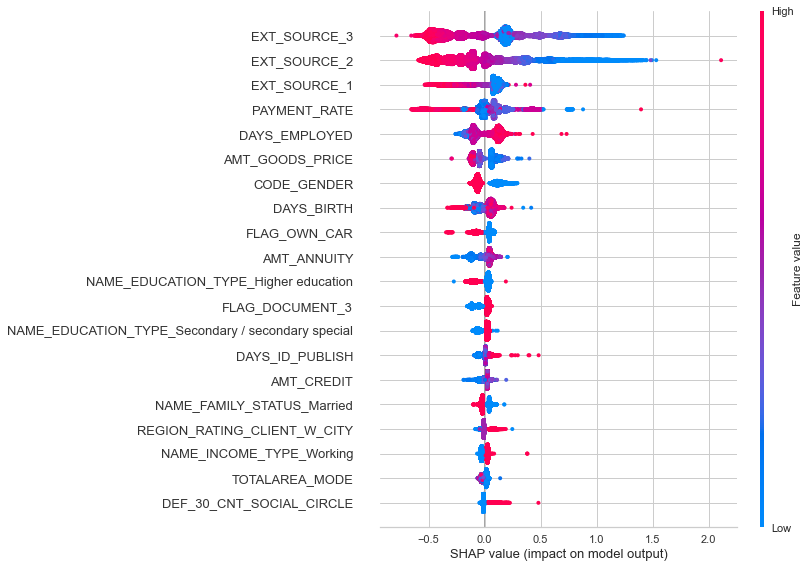

In [68]:
shap.initjs()
shap.summary_plot(shap_values, observations, feature_names = X_test.columns)

# LIME

In [58]:
import lime
from lime import lime_tabular

#explainer = lime_tabular.LimeTabularExplainer(
#    training_data = np.array(X_train),
#    feature_names = X_train.columns,
#    class_names = [0, 1],
#    mode = 'classification'
#)
classifier_gbc = make_pipeline(StandardScaler(), GradientBoostingClassifier(verbose = True))
Classifier_gbc_na , score  = fct_model.train_score_model(classifier_gbc ,X_train, y_train, X_test, y_test)

exp = fct_model.local_interpretability_lime(Classifier_gbc_na, X_train, X_test, 0)


      Iter       Train Loss   Remaining Time 
         1           0.5536            4.27m
         2           0.5479            4.24m
         3           0.5433            4.27m
         4           0.5396            4.51m
         5           0.5362            4.46m
         6           0.5336            4.38m
         7           0.5309            4.30m
         8           0.5287            4.25m
         9           0.5269            4.19m
        10           0.5247            4.16m
        20           0.5127            3.54m
        30           0.5060            3.09m
        40           0.5014            2.67m
        50           0.4984            2.22m
        60           0.4960            1.78m
        70           0.4940            1.34m
        80           0.4923           53.67s
        90           0.4910           26.96s
       100           0.4897            0.00s


In [46]:
X_train.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
96488,1,0,0,0,67500.0,314100.0,13306.5,225000.0,0.028663,-22074,...,0,0,0,0,0,0.108007,0.214900,33750.0,0.197133,0.042364
196993,0,1,0,1,112500.0,247675.5,26136.0,229500.0,0.018850,-18574,...,0,0,0,0,0,0.340153,0.454223,37500.0,0.232320,0.105525
155398,0,1,0,0,180000.0,835380.0,42651.0,675000.0,0.018029,-18578,...,0,0,0,0,0,0.140004,0.215471,90000.0,0.236950,0.051056
218104,0,0,0,0,157500.0,529348.5,39708.0,490500.0,0.020713,-20460,...,1,0,0,1,0,0.048974,0.297536,78750.0,0.252114,0.075013
207810,1,0,1,0,90000.0,900000.0,24880.5,900000.0,0.010643,-13734,...,0,1,0,1,0,0.027523,0.100000,45000.0,0.276450,0.027645


In [47]:
#print(classifier_gbr.predict_proba(X_test))

In [59]:
#exp = explainer.explain_instance(
#""    data_row = X_test.iloc[0], 
#    predict_fn = classifier_gbr.predict_proba
#)

exp.show_in_notebook(show_table=True)

In [ ]:
%matplotlib inline

In [ ]:
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()
    plt.show()

In [ ]:
print(exp.as_list())

# Feature selection

In [ ]:
#https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectFromModel( LogisticRegression(solver='liblinear', verbose = True), max_features=10)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

Scaler = StandardScaler()

X_train_ = Scaler.fit_transform(X_train)
X_test_ = Scaler.transform(X_test)

X_train_fs, X_test_fs, fs = select_features(X_train_, y_train, X_test_)
model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))
model.fit(X_train_fs, y_train)
print('perf logistic Standard Scaler : ', roc_auc_score(y_test, [i[1] for i in model.predict_proba(X_test_fs)]))

In [ ]:
num_feats = 30
cor_support, cor_feature = fct_model.cor_selector(X_train_, y_train,num_feats)
chi_support, chi_feature = fct_model.chi_selector(X_train_, y_train,num_feats)
rfe_support, rfe_feature = fct_model.rfe_selector(X_train_, y_train,num_feats)
embeded_lr_support, embeded_lr_feature = fct_model.embeded_selector(X_train_, y_train,num_feats, LogisticRegression(penalty="l1", solver = 'liblinear'))
embeded_rf_support, embeded_rf_feature = fct_model.embeded_selector(X_train_, y_train,num_feats, RandomForestClassifier(n_estimators=100, verbose = 5))

In [ ]:
feature_name = X_train.columns
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(3*num_feats)

In [ ]:
feature_choisi = pd.DataFrame({})
feature_choisi['support'] = fs.get_support()
feature_choisi['Variable'] = X_train.columns
print(feature_choisi[feature_choisi['support'] == True].iloc[:40])

In [ ]:
X_train.columns

In [ ]:
num_feats = 30

X_train_= pd.DataFrame(X_train_, columns = X_train.columns)

def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature



cor_support, cor_feature = cor_selector(X_train_, y_train,num_feats)
print(str(len(cor_feature)), 'selected features')

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

chi_selector = SelectKBest(chi2, k=num_feats)
X_norm = MinMaxScaler((0,1)).fit_transform(X_train_)
chi_selector.fit(X_norm, y_train)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(max_iter = 1000), n_features_to_select=num_feats, step=30, verbose=5)
rfe_selector.fit(X_train_, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')


In [ ]:

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver = 'liblinear'), max_features=num_feats)
embeded_lr_selector.fit(X_train_, y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, verbose = 5), max_features=num_feats)
embeded_rf_selector.fit(X_train_, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')


In [ ]:
feature_name = X_train.columns
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(3*num_feats)

In [ ]:
feat_importante = feature_selection_df.iloc[:3*num_feats]['Feature']
X_train_fs = X_train[feat_importante]
X_test_fs = X_test[feat_importante]
model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', verbose = True))
model.fit(X_train_fs, y_train)

print('perf logistique avec feature selecte : ', roc_auc_score(y_test, [i[1] for i in model.predict_proba(X_test_fs)]))

model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', verbose = True))
model.fit(X_train, y_train)

print('perf logistique avec all feature : ', roc_auc_score(y_test, [i[1] for i in model.predict_proba(X_test)]))

In [ ]:
feat_importante = feature_selection_df.iloc[:num_feats]['Feature']
X_train_fs = X_train[feat_importante]
X_test_fs = X_test[feat_importante]
model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', verbose = True))
model.fit(X_train_fs, y_train)

print('perf logistique avec feature selecte : ', roc_auc_score(y_test, [i[1] for i in model.predict_proba(X_test_fs)]))

In [ ]:
feat_importante = feature_selection_df.iloc[:num_feats]['Feature']
X_train_fs = X_train[feat_importante]
X_test_fs = X_test[feat_importante]
model = make_pipeline(StandardScaler(), GradientBoostingClassifier( verbose = 10))
model.fit(X_train_fs, y_train)

print('perf gbc avec feature selecte : ', roc_auc_score(y_test, [i[1] for i in model.predict_proba(X_test_fs)]))

## Modele tuné

In [ ]:
from sklearn.model_selection import GridSearchCV
# Avec recherche hyperparam

feat_importante = feature_selection_df.iloc[:num_feats]['Feature']
X_train_fs = X_train[feat_importante]
X_test_fs = X_test[feat_importante]


model = make_pipeline(StandardScaler(), GradientBoostingClassifier( verbose = 10))


param_grid_gbc = {
    'gradientboostingclassifier__learning_rate' : np.linspace(10**(-2), 1, 3),
    'gradientboostingclassifier__n_estimators' : [50, 100, 200],
    'gradientboostingclassifier__max_depth' : [3, 4]
}

model_tune = GridSearchCV(model, param_grid = param_grid_gbc, cv = 5, verbose = 10, n_jobs = -1, scoring = 'roc_auc')
model_tune.fit(X_train_fs, y_train)


print('perf gbc avec feature selecte : ', roc_auc_score(y_test, [i[1] for i in model_tune.predict_proba(X_test_fs)]))

In [ ]:
feature_importance_model(clf, X_train)



Feat_imp = pd.DataFrame({})

Feat_imp['imp'] = np.abs(model_tune.best_estimator_[-1].feature_importances_)
Feat_imp['Variable'] = X_train_fs.columns
print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:40])

## Comportement du modéle tuné avec feature select

In [ ]:
fct_model.impact_proba(model_tune, X_test_fs, y_test)

In [ ]:
defaut = pd.DataFrame({})
defaut['defaut'] = y_test
defaut['proba'] =[i[1] for i in model_tune.predict_proba(X_test_fs)]

sns.histplot(data= defaut, x= 'proba', hue = 'defaut')
plt.show()

In [ ]:
seuils = np.linspace(-0.01, defaut['proba'].max(), 30)

liste_accepte=[]
liste_rejete=[]
liste_tx_rejete=[]
liste_tx_defaut_accepte=[]
liste_tx_defaut_rejete = []



for seuil in seuils:
    defaut[f'Dossiers_rejete_{round(seuil, 3)}'] = np.where(
        defaut['proba'] < seuil, 0, 1)
    Nb_dossiers = defaut[f'Dossiers_rejete_{round(seuil, 3)}'].count()
    Nb_dossiers_rejete = defaut[f'Dossiers_rejete_{round(seuil, 3)}'].sum()
    Nb_dossiers_accepte = Nb_dossiers - Nb_dossiers_rejete
    Nb_dossiers_defaut_accepte = defaut[defaut['defaut'] == 1][
        defaut[f'Dossiers_rejete_{round(seuil, 3)}'] ==
        0][f'Dossiers_rejete_{round(seuil, 3)}'].count()
    Nb_dossiers_defaut_rejete = defaut[defaut['defaut'] == 1][
        defaut[f'Dossiers_rejete_{round(seuil, 3)}'] ==
        1][f'Dossiers_rejete_{round(seuil, 3)}'].count()
    
    liste_accepte.append(Nb_dossiers_accepte)
    liste_rejete.append(Nb_dossiers_rejete)
    liste_tx_rejete.append( Nb_dossiers_rejete / Nb_dossiers)
    liste_tx_defaut_accepte.append(Nb_dossiers_defaut_accepte / (Nb_dossiers_accepte))
    liste_tx_defaut_rejete.append(Nb_dossiers_defaut_rejete/ Nb_dossiers_rejete)
    print('########')
    print(seuil, ' : Accepte : ',Nb_dossiers_accepte ,
          '\n Rejete :', Nb_dossiers_rejete)
    print('Tx de rejete: ', Nb_dossiers_rejete / Nb_dossiers)
    print('Tx de defaut Accepte',
          Nb_dossiers_defaut_accepte / (Nb_dossiers_accepte))
    print('Tx de defaut rejete', Nb_dossiers_defaut_rejete/ Nb_dossiers_rejete)

In [ ]:
plt.plot(seuils, liste_accepte)
plt.plot(seuils, liste_rejete)
plt.show()
plt.plot(seuils, liste_tx_rejete)
plt.plot(seuils, liste_tx_defaut_accepte)
plt.plot(seuils, liste_tx_defaut_rejete)
plt.show()

In [ ]:
defaut

In [ ]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data = np.array(X_train_fs),
    feature_names = X_train_fs.columns,
    class_names = [0, 1],
    mode = 'classification'
)

In [ ]:
print(model.predict_proba(X_test_fs))

In [ ]:
exp = explainer.explain_instance(
    data_row = X_test_fs.iloc[0], 
    predict_fn = model.predict_proba
)

exp.show_in_notebook(show_table=True)

In [ ]:
%matplotlib inline

In [ ]:
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()
    plt.show()

In [ ]:
print(exp.as_list())

In [ ]:
sns.barplot([i[1] for i in exp.as_list()], [i[0] for i in exp.as_list()])

# Essai de SMOTE sur le modèle avec moins de variable

In [ ]:
from imblearn.over_sampling import SMOTE

X_resampled_fs, y_resampled_fs = SMOTE(random_state = 0).fit_resample(X_train_fs, y_train)

print(X_resampled_fs.shape)
model = GradientBoostingClassifier(n_estimators = 200,  verbose = 10)
model.fit(X_resampled_fs,y_resampled_fs)

In [ ]:
roc_auc_score(y_test, [i[1] for i in model.predict_proba(X_test_fs)])

In [ ]:
Feat_imp = pd.DataFrame({})

Feat_imp['imp'] = np.abs(model.feature_importances_)
Feat_imp['Variable'] = X_train_fs.columns
print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:40])

## Comportement SMOTE + feat_select

In [ ]:
defaut = pd.DataFrame({})
defaut['defaut'] = y_test
defaut['proba'] =[i[1] for i in model.predict_proba(X_test_fs)]

sns.histplot(data= defaut, x= 'proba', hue = 'defaut')
plt.show()

In [ ]:
seuils = np.linspace(-0.01, defaut['proba'].max(), 30)

liste_accepte=[]
liste_rejete=[]
liste_tx_rejete=[]
liste_tx_defaut_accepte=[]
liste_tx_defaut_rejete = []



for seuil in seuils:
    defaut[f'Dossiers_rejete_{round(seuil, 3)}'] = np.where(
        defaut['proba'] < seuil, 0, 1)
    Nb_dossiers = defaut[f'Dossiers_rejete_{round(seuil, 3)}'].count()
    Nb_dossiers_rejete = defaut[f'Dossiers_rejete_{round(seuil, 3)}'].sum()
    Nb_dossiers_accepte = Nb_dossiers - Nb_dossiers_rejete
    Nb_dossiers_defaut_accepte = defaut[defaut['defaut'] == 1][
        defaut[f'Dossiers_rejete_{round(seuil, 3)}'] ==
        0][f'Dossiers_rejete_{round(seuil, 3)}'].count()
    Nb_dossiers_defaut_rejete = defaut[defaut['defaut'] == 1][
        defaut[f'Dossiers_rejete_{round(seuil, 3)}'] ==
        1][f'Dossiers_rejete_{round(seuil, 3)}'].count()
    
    liste_accepte.append(Nb_dossiers_accepte)
    liste_rejete.append(Nb_dossiers_rejete)
    liste_tx_rejete.append( Nb_dossiers_rejete / Nb_dossiers)
    liste_tx_defaut_accepte.append(Nb_dossiers_defaut_accepte / (Nb_dossiers_accepte))
    liste_tx_defaut_rejete.append(Nb_dossiers_defaut_rejete/ Nb_dossiers_rejete)
    print('########')
    print(seuil, ' : Accepte : ',Nb_dossiers_accepte ,
          '\n Rejete :', Nb_dossiers_rejete)
    print('Tx de rejete: ', Nb_dossiers_rejete / Nb_dossiers)
    print('Tx de defaut Accepte',
          Nb_dossiers_defaut_accepte / (Nb_dossiers_accepte))
    print('Tx de defaut rejete', Nb_dossiers_defaut_rejete/ Nb_dossiers_rejete)

In [ ]:
plt.plot(seuils, liste_accepte)
plt.plot(seuils, liste_rejete)
plt.show()
plt.plot(seuils, liste_tx_rejete)
plt.plot(seuils, liste_tx_defaut_accepte)
plt.plot(seuils, liste_tx_defaut_rejete)
plt.show()

In [ ]:
index = 5 

ind_test = X_test_fs.iloc[index: index+1]
print(model.predict_proba(ind_test)[0][1])

In [ ]:
import pickle

X_test_fs_id_cli = pd.concat([X_test_fs, app_train[['SK_ID_CURR']]], axis = 1, ignore_index = True)
with open('data_test.pkl', 'wb') as f:
    pickle.dump(X_test_fs_id_cli, f)

    
X_train_fs_id_cli = pd.concat([X_train_fs, app_train[['SK_ID_CURR']]], axis = 1, ignore_index = True)
with open('data_train.pkl', 'wb') as f:
    pickle.dump(X_train_fs_id_cli, f)
    
    
with open('classifier.pkl', 'wb') as f:
    pickle.dump(model, f)
    


In [78]:
print(X_test)
X_test_fs_id_cli = pd.concat([X_test, app_train.iloc[test_index][['SK_ID_CURR']]], axis = 1)
id_cli = 387758
print(X_test_fs_id_cli[X_test_fs_id_cli['SK_ID_CURR'] == id_cli].drop(['SK_ID_CURR'], axis =1))

        CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
248727            1             1                0             0   
263686            0             1                0             0   
264746            0             1                0             1   
139119            1             1                0             1   
23810             1             0                0             0   
...             ...           ...              ...           ...   
95738             1             0                0             0   
61549             1             0                1             2   
55473             0             1                0             0   
32719             1             0                0             0   
52089             0             0                0             0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
248727           90000.0    360000.0      20232.0         360000.0   
263686          306000.0    865953.0      3

In [75]:
app_train.iloc[test_index]

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
248727,387758,0,1,1,0,0,90000.0,360000.0,20232.0,360000.0,...,0,0,0,0,0,0.366862,0.250000,45000.0,0.224800,0.056200
263686,405300,0,0,1,0,0,306000.0,865953.0,32980.5,774000.0,...,1,0,0,1,0,0.150543,0.353368,306000.0,0.107779,0.038086
264746,406580,0,0,1,0,1,225000.0,180000.0,9000.0,180000.0,...,0,0,0,0,0,0.071745,1.250000,75000.0,0.040000,0.050000
139119,261310,0,1,1,0,1,157500.0,528633.0,22527.0,472500.0,...,1,0,0,1,0,0.557264,0.297938,52500.0,0.143029,0.042614
23810,127703,0,1,0,0,0,112500.0,59346.0,4725.0,54000.0,...,0,1,0,1,0,0.065989,1.895663,56250.0,0.042000,0.079618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95738,211142,0,1,0,0,0,135000.0,1336873.5,35977.5,1138500.0,...,1,0,0,1,0,0.247897,0.100982,67500.0,0.266500,0.026912
61549,171385,0,1,0,1,2,90000.0,373500.0,10399.5,225000.0,...,0,0,0,1,0,0.136033,0.240964,22500.0,0.115550,0.027843
55473,164279,0,0,1,0,0,148500.0,216630.0,17113.5,216630.0,...,0,0,0,0,0,0.158087,0.685501,74250.0,0.115242,0.078999
32719,137920,0,1,0,0,0,261000.0,323388.0,34443.0,292500.0,...,0,1,0,1,0,0.025064,0.807080,261000.0,0.131966,0.106507
